In [1]:
import json
import random
from random import shuffle

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import seaborn as sns
from collections import Counter

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW

2023-05-26 22:02:05.517874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 22:02:06.002373: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-26 22:02:06.002415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-26 22:02:06.002419: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
import transformers
transformers.logging.set_verbosity_error()

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_everything()

In [6]:
max_length = 512
batch_size = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
train = pd.read_parquet('hackathon_files_for_participants_ozon/train_data.parquet')

In [8]:
train["cat3"] = train["categories"].apply(lambda x: json.loads(x)["3"])
cat3_counts = train["cat3"].value_counts().to_dict()

In [9]:
train_cat = train[['variantid', 'categories']]
train_cat['cat3_grouped'] = train_cat.categories.apply(lambda x: json.loads(x)['3'] if cat3_counts[json.loads(x)['3']] > 1000 else "rest")

/tmp/ipykernel_1039378/2486514628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cat['cat3_grouped'] = train_cat.categories.apply(lambda x: json.loads(x)['3'] if cat3_counts[json.loads(x)['3']] > 1000 else "rest")


In [10]:
train['text'] = 'name: ' + train['name'] + ' ' + train['characteristic_attributes_mapping'].fillna('{}')

In [11]:
id2name = train[['variantid', 'text']].set_index('variantid').to_dict()['text']

In [12]:
train_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/train_pairs.parquet')

In [13]:
train_df, val_df, _, _ = train_test_split(train_pairs, train_pairs.target, test_size=0.1)

In [14]:
train_df = train_df[(~train_df.variantid1.isin(val_df.variantid1) 
          & ~train_df.variantid1.isin(val_df.variantid2) 
          & ~train_df.variantid2.isin(val_df.variantid1) 
          & ~train_df.variantid2.isin(val_df.variantid2))]

In [15]:
train_df_1 = train_df.copy()

In [16]:
train_df_1.columns = ['target', 'variantid2', 'variantid1']

In [17]:
train_df = pd.concat([train_df, train_df_1])

In [18]:
val_df_cat = val_df.merge(train_cat, left_on='variantid1', right_on='variantid')

In [19]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

In [20]:
class ProductDataset(Dataset):

    def __init__(self, meta, id2name):
        self.meta = meta
        self.id2name = id2name

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        line = self.meta.iloc[idx]
        inputs = tokenizer(
            self.id2name[line.variantid1].lower(), 
            text_pair=self.id2name[line.variantid2].lower(), 
            return_tensors='pt', 
            padding='max_length', 
            truncation=True, 
            max_length=max_length
        )
        for i in inputs:
            inputs[i] = inputs[i][0]

        return inputs, int(line.target)


In [21]:
train_dataset = ProductDataset(meta=train_df, id2name=id2name)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=20)

val_dataset = ProductDataset(meta=val_df, id2name=id2name)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=20)

In [22]:
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-large', num_labels=1)
model.to(device)

/home/vladimir/.virtualenvs/ml/lib/python3.10/site-packages/transformers/modeling_utils.py:402: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
/home/vladimir/.virtualenvs/ml/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/vladimir/.virtualenvs/ml/lib/python3.10/site-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the fu

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fe

In [23]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-6)

/home/vladimir/.virtualenvs/ml/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
for _ in range(3):
    model.train()
    train_loss = 0
    
    for batch, targets in tqdm(train_dataloader):
        for i in batch:
            batch[i] = batch[i].to(device)

        targets = targets.to(device)
      
        optimizer.zero_grad()
      
        loss = model(**batch, labels=targets.float())
        loss[0].backward()
        
        optimizer.step()
        
        train_loss += loss[0].item()
      
    print("Loss: {0:.5f}".format(train_loss / len(train_dataloader)))
    
    model.eval()

    valid_preds, valid_labels = [], []

    for batch, targets in tqdm(val_dataloader): 
        for i in batch:
            batch[i] = batch[i].to(device)

        with torch.no_grad():
            logits = model(**batch)

        logits = logits.logits.detach().cpu()

        batch_preds = logits.numpy()
        batch_labels = targets.numpy()
        valid_preds.extend(batch_preds)
        valid_labels.extend(batch_labels)

    valid_preds = np.array(valid_preds)
    print("roc_auc: " + str(roc_auc_score(valid_labels, valid_preds)))
    
    pred_val_df = val_df.drop('target', axis=1)
    pred_val_df['scores'] = valid_preds
    
    print('pr_auc_macro', pr_auc_macro(val_df_cat, pred_val_df))

  0%|          | 0/58248 [00:00<?, ?it/s]

Loss: 0.09875


  0%|          | 0/3832 [00:00<?, ?it/s]

roc_auc: 0.9296265315055317
pr_auc_macro 0.7295574135120465


  0%|          | 0/58248 [00:00<?, ?it/s]

Loss: 0.09304


  0%|          | 0/3832 [00:00<?, ?it/s]

roc_auc: 0.928494241855927
pr_auc_macro 0.7214389627964184


  0%|          | 0/58248 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [41]:
model.eval()

valid_preds, valid_labels = [], []

for batch, targets in tqdm(val_dataloader): 
    for i in batch:
        batch[i] = batch[i].to(device)

    with torch.no_grad():
        logits = model(**batch)

    logits = logits.logits.detach().cpu()

    batch_preds = logits.numpy()
    batch_labels = targets.numpy()
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

valid_preds = np.array(valid_preds)
print("roc_auc: " + str(roc_auc_score(valid_labels, valid_preds)))

pred_val_df = val_df.drop('target', axis=1)
pred_val_df['scores'] = valid_preds

print('pr_auc_macro', pr_auc_macro(val_df_cat, pred_val_df))

  0%|          | 0/3832 [00:00<?, ?it/s]

roc_auc: 0.9278189691630682
pr_auc_macro 0.7212826296320857


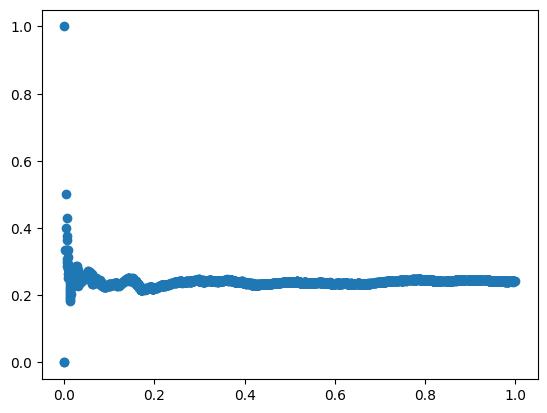

In [42]:
y, x, thr = precision_recall_curve(val_df_cat[val_df_cat.cat3_grouped == val_df_cat.cat3_grouped.unique()[5]].target, 
                                   pred_val_df[(val_df_cat.cat3_grouped == val_df_cat.cat3_grouped.unique()[5]).tolist()]['scores'])
import matplotlib.pyplot as plt
plt.scatter(x, y)

In [27]:
model.save_pretrained('model')

In [43]:
test = pd.read_parquet('hackathon_files_for_participants_ozon/test_data.parquet')

In [44]:
test['text'] = 'name: ' + test['name'] + ' ' + test['characteristic_attributes_mapping'].fillna('{}')

In [45]:
test_id2name = test[['variantid', 'text']].set_index('variantid').to_dict()['text']

In [46]:
test_pairs = pd.read_parquet('hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet')

In [47]:
class TestProductDataset(Dataset):

    def __init__(self, meta, id2name):
        self.meta = meta
        self.id2name = id2name

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        line = self.meta.iloc[idx]
        inputs = tokenizer(
            self.id2name[line.variantid1].lower(), 
            text_pair=self.id2name[line.variantid2].lower(), 
            return_tensors='pt', 
            padding='max_length', 
            truncation=True, 
            max_length=max_length
        )
        for i in inputs:
            inputs[i] = inputs[i][0]

        return inputs, 0

In [48]:
test_dataset = TestProductDataset(meta=test_pairs, id2name=test_id2name)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=20)

In [49]:
model.eval()

test_preds = []

for batch, targets in tqdm(test_dataloader): 
    for i in batch:
        batch[i] = batch[i].to(device)

    with torch.no_grad():
        logits = model(**batch)

    logits = logits.logits.detach().cpu()

    batch_preds = logits.numpy()
    test_preds.extend(batch_preds)

test_preds = np.array(test_preds)

  0%|          | 0/2261 [00:00<?, ?it/s]

In [50]:
# test["cat3"] = test["categories"].apply(lambda x: json.loads(x)["3"])
# test["cat3_grouped"] = test["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [51]:
# test_pairs = test_pairs.merge(test[['variantid', 'cat3_grouped']], left_on='variantid1', right_on='variantid').drop('variantid', axis=1)

In [52]:
test_pairs['target'] = test_preds

In [53]:
test_pairs.to_csv('submission.csv', index=False)

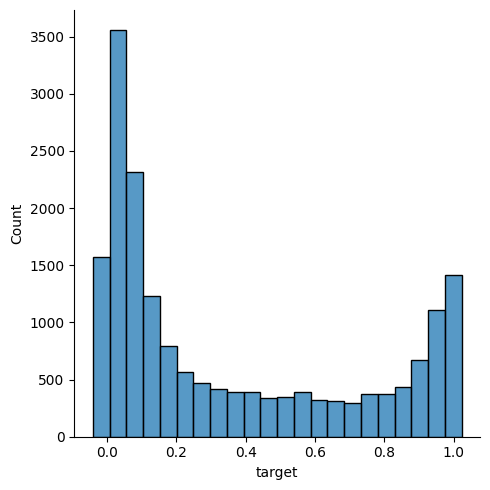

In [54]:
import seaborn as sns
sns.displot(test_pairs.target)